In [44]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import jax.random as jr
import jax.numpy as np
import dLux as dl
import matplotlib.pyplot as plt

# Set global plotting parameters
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120


def toRad(arcsecs):
    return arcsecs * np.pi / (180*3600)

In [45]:
wavels = np.array([2.82792251e-06])
weights = np.array([1])

spec = dl.Spectrum(wavels, weights)

source_offset_x = toRad(0.035)
source_offset_y = toRad(-0.017)

offset = np.array([source_offset_x, source_offset_y])

flux = np.exp(8)

source = dl.PointSource(wavelengths=wavels, spectrum=spec, position=offset, flux=flux)

In [46]:
# Aperture properties
wf_npix = 128
radial_terms = [2, 3]
true_coeffs = 1e-9 * jr.normal(jr.PRNGKey(0), (7,))
aperture = dl.ApertureFactory(wf_npix, radial_orders=radial_terms, coefficients=true_coeffs)

# Psf properties
psf_npixels = 16
psf_pixel_scale = 0.03

# Construct
diameter = 6
optics = dl.AngularOptics(wf_npix, diameter, aperture, psf_npixels, psf_pixel_scale)

# Construct Telescope
telescope = dl.Instrument(optics, (source,'source'))

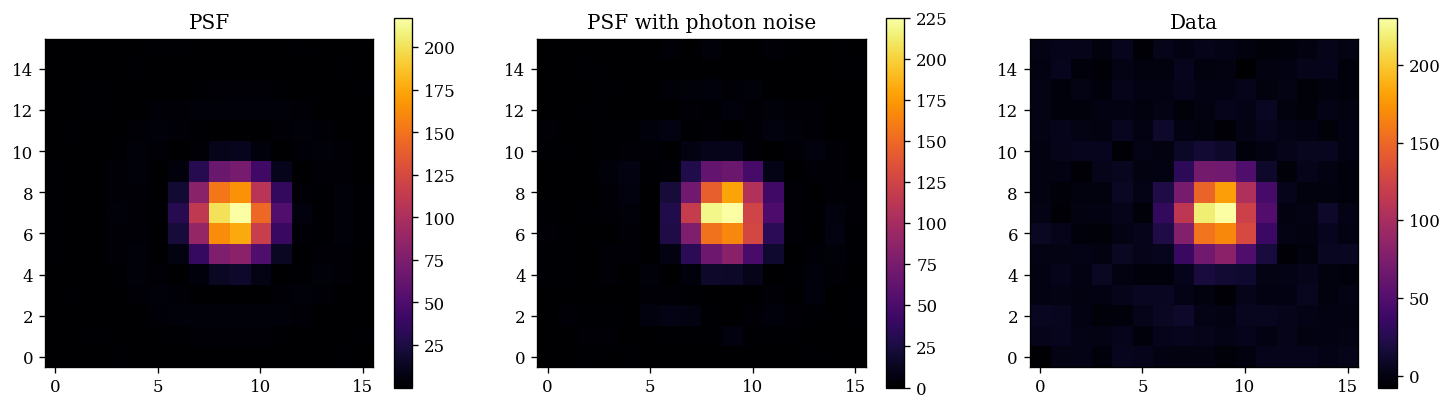

In [47]:
 ## Generate psf
psf = telescope.model()
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 3*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data = psf_photon + bg_noise

#data = psf

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("PSF with photon noise")
plt.imshow(psf_photon)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Data")
plt.imshow(data)
plt.colorbar()
plt.show()

In [48]:
# PPL
import numpyro as npy
import numpyro.distributions as dist

parameters = ['position', 'flux']
#parameters = ['position']

def psf_model(data, data_err, model):
    """
    Define the numpyro function
    """
    
    x_sample = npy.sample("x",        dist.Uniform(-0.10, 0.10))
    y_sample = npy.sample("y",        dist.Uniform(-0.10, 0.10))
    flux_sample = npy.sample("log_flux", dist.Uniform(7, 9))
    
    det_flux = np.exp(flux_sample)
    det_x = toRad(x_sample)
    det_y = toRad(y_sample)
    
    values = [
        [det_x, det_y],
        det_flux
    ]

    with npy.plate("data", len(data.flatten())):
        dist_model = dist.Normal(model.set(parameters, values).model().flatten(), data_err)
        npy.sample("psf", dist_model, obs=data.flatten())

In [49]:
data_err = 3 * np.ones_like(data.flatten())

In [50]:
from jax import device_count
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=2000,
    num_samples=2000,
    num_chains=device_count(),
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data, data_err, telescope)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 53.3 s, sys: 3.22 s, total: 56.6 s
Wall time: 15 s


In [51]:
sampler.print_summary()
values_out = sampler.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  log_flux      8.00      0.01      8.00      8.00      8.01   7593.07      1.00
         x      0.04      0.00      0.04      0.03      0.04   8759.51      1.00
         y     -0.02      0.00     -0.02     -0.02     -0.02   9123.47      1.00

Number of divergences: 0


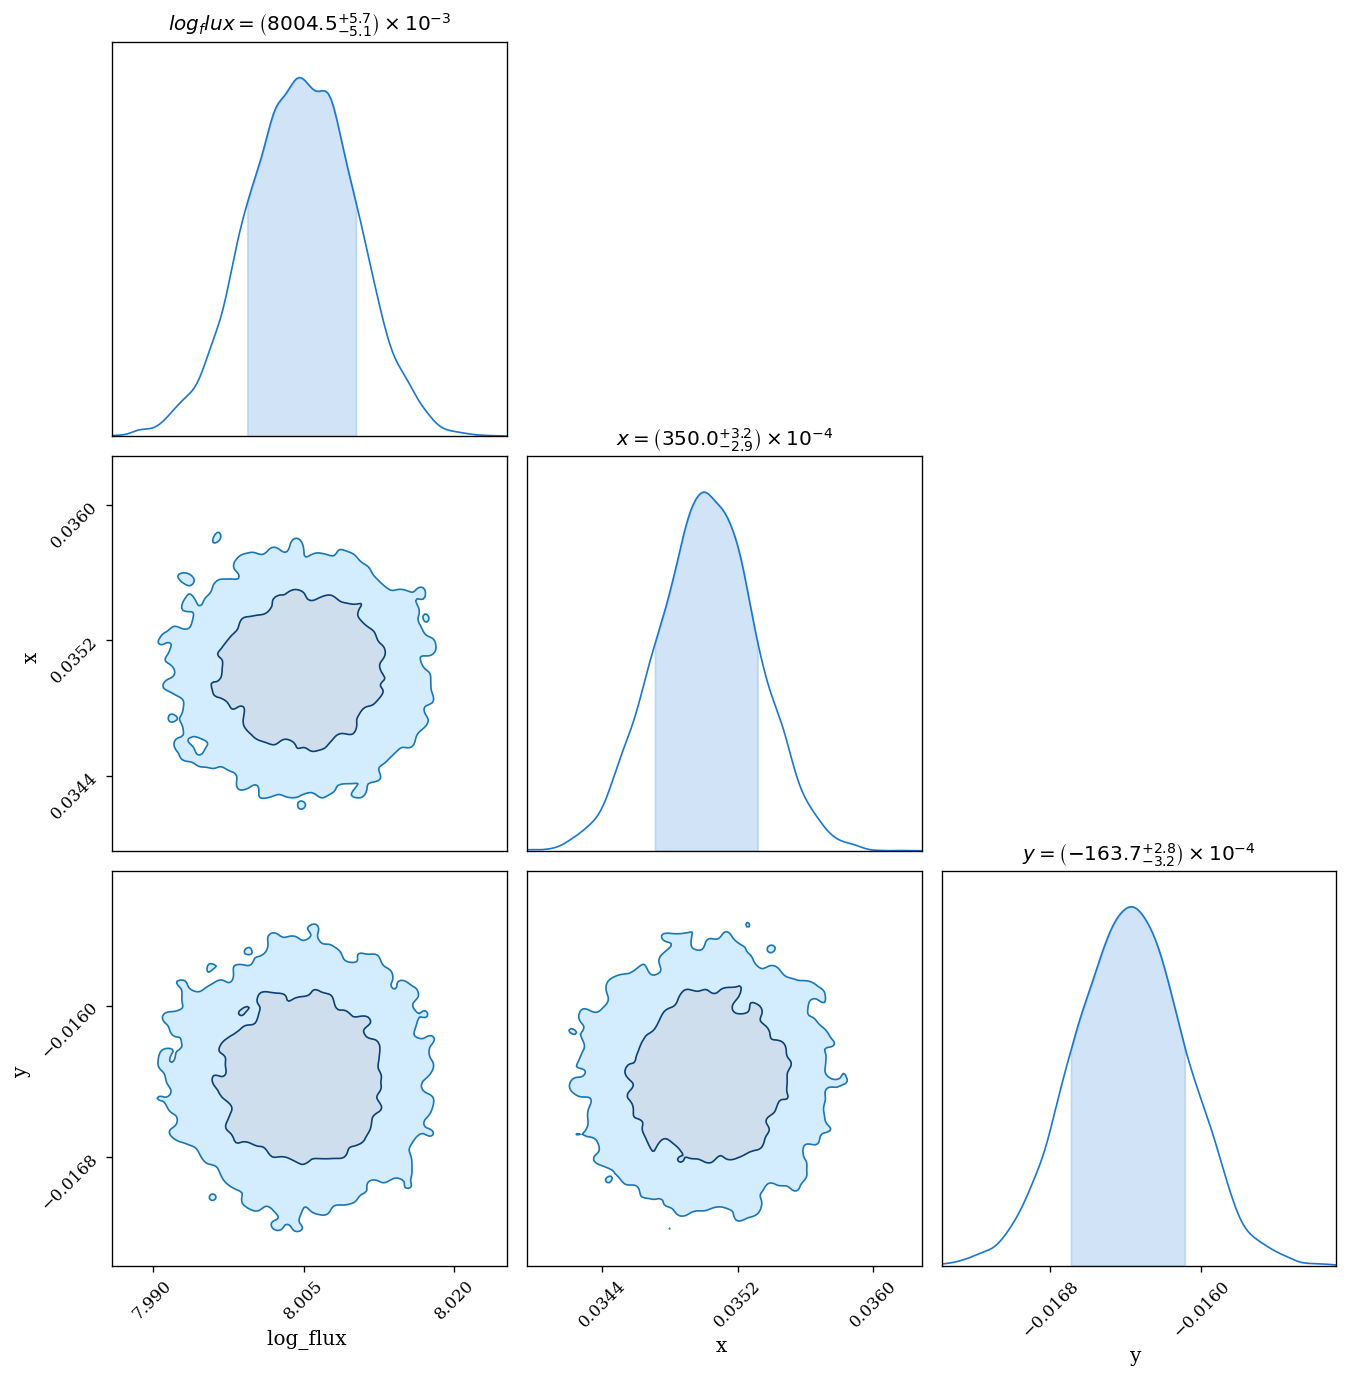

In [52]:
import chainconsumer as cc

chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot()
fig.set_size_inches((12,12));

array([[<Axes: title={'center': 'log_flux'}>,
        <Axes: title={'center': 'log_flux'}>],
       [<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'y'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

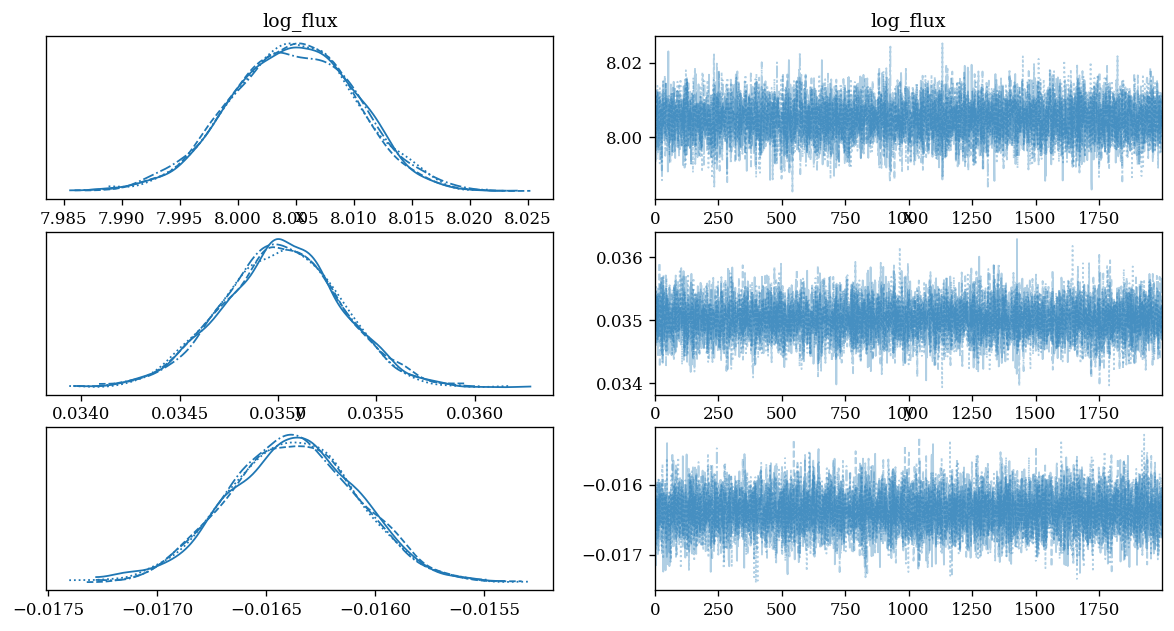

In [54]:

import arviz as az
az.plot_trace(az.from_numpyro(sampler))